In [99]:
# 出走馬について上位に入る確率を予想し、確率が閾値以上の場合に限り購入することを考える
# 閾値を使わずに購入した場合と閾値以上の場合で比較し、的中率や回収率が改善されるか確認する

In [383]:
# インポート
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
# ! pip install japanize-matplotlib
import japanize_matplotlib
from scipy import stats

In [741]:
# CSVファイルの読み込み
# df = pd.read_csv('input_編集後.csv', encoding='utf-8')
num_horses = 10
df = pd.read_csv(f'input_{num_horses}頭_編集後.csv', encoding='utf-8')
df['race_date'] = pd.to_datetime(df['race_date'])  # 日付が文字列なら変換
print(f"dfの行数は {len(df)} ")
# レースID、馬番順に並び替え
df = df.sort_values(by=['race_id', 'horse_number'])

dfの行数は 135630 


In [743]:

def confidence_interval(mean: float, std: float, n: int, confidence: float = 0.95):

    """
    回収率の信頼区間を求める関数

    Parameters
    ----------
    mean       : float           平均回収率（例：1.05）
    std        : float           標準偏差  （例：0.15）
    n          : int             サンプル数（レース数）
    confidence : float, optional 信頼水準（デフォルトは0.95）

    Returns
    -------
    (lower, upper) : tuple of float
        信頼区間の下限値と上限値
    """
    
    # t値（t分布の臨界値）
    t_value = stats.t.ppf((1 + confidence) / 2, df=n-1)
    
    # 信頼区間の幅（マージン）
    margin = t_value * std / np.sqrt(n)
    
    # 区間の下限・上限
    lower = mean - margin
    upper = mean + margin
    
    return lower, upper
    

In [745]:
# === 欠損値対応の設定 ===
handle_missing = True  # Trueで対応ON、Falseでスキップ
min_non_missing_horses = 10  # この頭数以上であれば補完、それ未満ならレースごと除外

# 欠損処理対象の特徴量を指定（必要に応じて拡張）
missing_check_features = [
    'time_index_average_2',
    'jockey_place_rate_100'
]

def handle_missing_val(df, features, enabled, min_horses):
    if not enabled:
        print("⚠ 欠損処理はスキップされました。")
        return df

    print("✅ 欠損処理を開始します...")
    valid_race_ids = []
    processed_groups = []

    for race_id, group in df.groupby('race_id'):
        # 欠損がない行数をカウント
        non_missing_mask = group[features].notnull().all(axis=1)
        non_missing_count = non_missing_mask.sum()

        if non_missing_count < min_horses:
            # → 指定頭数未満 → 除外
            continue
        else:
            # → 指定頭数以上 → 平均値で補完
            for col in features:
                if group[col].isnull().any():
                    mean_val = group[col].mean(skipna=True)
                    group[col] = group[col].fillna(mean_val)
            processed_groups.append(group)

    df_processed = pd.concat(processed_groups, ignore_index=True)
    print(f"✅ 欠損処理後のレコード数: {len(df_processed)}（元: {len(df)}）")
    return df_processed

# === 欠損処理の実行 ===
df_not_handle_missing_val = df.copy()
df_handle_missing_val = handle_missing_val(
    df_not_handle_missing_val,
    features=missing_check_features,
    enabled=handle_missing,
    min_horses=min_non_missing_horses
)


✅ 欠損処理を開始します...
✅ 欠損処理後のレコード数: 82140（元: 135630）


In [747]:
# ---------- 説明変数 ----------------------------
df_feature = df_handle_missing_val.copy()
race_avg_time_index = df_feature.groupby('race_id')['time_index_average_2'].transform('mean')
df_feature['time_index_diff_from_avg'] = df_feature['time_index_average_2'] - race_avg_time_index
race_avg_jockey_place_rate = df_feature.groupby('race_id')['jockey_place_rate_100'].transform('mean')
df_feature['jockey_place_rate_diff_from_avg'] = df_feature['jockey_place_rate_100'] - race_avg_jockey_place_rate
features = [
    'time_index_diff_from_avg',
    'jockey_place_rate_diff_from_avg',
]
# ---------- リーク防止のラベル一括作成 ----------
# 上位4頭 → is_top4
df_feature['is_top4'] = (
    df_feature.groupby('race_id')['finish_rank']
    .rank(method='first') <= num_horses / 2 
).astype(int)

In [749]:
# フィルタ条件を適用
filtered_df = df_feature.copy()
## 年
train_year = 2022
valid_year = 2023
if train_year < valid_year:
    min_year = train_year
    max_year = valid_year
else:
    min_year = valid_year
    max_year = train_year
filtered_df = filtered_df[
    (filtered_df['race_date'].dt.year >= min_year) &
    (filtered_df['race_date'].dt.year <= max_year)
]
## 人気
# filtered_df = filtered_df[filtered_df['popularity'] == 2]

# カウント
print(f"filtered_dfの行数は {len(filtered_df)} ")

filtered_dfの行数は 35960 


In [753]:
# ---------- モデル1 ----------
df_m1 = filtered_df.copy()

# ---------- 各モデルの特徴量と目的変数 ----------
X_m1 = df_m1[features]
y_m1 = df_m1['is_top4']

X_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_m1.csv', index=False, encoding='cp932')
y_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_m1.csv', index=False, encoding='cp932')

# ---------- モデル1の学習 ----------
X_train_m1 = X_m1[df_m1['race_date'].dt.year == train_year]
y_train_m1 = y_m1[df_m1['race_date'].dt.year == train_year]
X_val_m1   = X_m1[df_m1['race_date'].dt.year == valid_year]
y_val_m1   = y_m1[df_m1['race_date'].dt.year == valid_year]

base_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
}

model1 = xgb.XGBClassifier(
    **base_params,
    base_score = 0.5,
    max_depth=3,
    learning_rate=0.06,
    n_estimators=100,
    reg_alpha=0.5,
    reg_lambda=1.0
)
model1.fit(X_train_m1, y_train_m1)

X_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_train_m1.csv', index=False, encoding='cp932')
y_train_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_train_m1.csv', index=False, encoding='cp932')
X_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\X_val_m1.csv', index=False, encoding='cp932')
y_val_m1.to_csv('C:\\Users\\ryo\\Downloads\\y_val_m1.csv', index=False, encoding='cp932')

# ============================================================
# ✅ 推論フェーズ（レース単位で順にモデルを適用して1着を予測）
# ============================================================

# 対象とする検証データのみ
df_test = filtered_df[filtered_df['race_date'].dt.year == valid_year].copy()

# 結果格納リスト
full_predictions = []

for race_id, group in df_test.groupby('race_id'):

    # ---------- モデル1 ----------
    group_m1 = group.copy()
    X_test_m1 = group_m1[features]
    group_m1['pred_prob_m1'] = model1.predict_proba(X_test_m1)[:, 1]
    # 上位4頭を選出
    group_m1 = group_m1.sort_values('pred_prob_m1', ascending=False)
    group_m1['selected_in_m1'] = 0
    group_m1.iloc[:int(num_horses / 2), group_m1.columns.get_loc('selected_in_m1')] = 1

    # ✅ finish_rank も含めて出力
    result_cols = [
        'race_id', 'course_id', 'num_horses', 'race_number', 'weather_name', 'track_condition_name', 'horse_number', 'finish_rank', 'popularity', 'odds', 'pred_prob_m1', 'selected_in_m1'
    ] + features

    full_predictions.append(group_m1[result_cols])

# 全レース結合
full_pred_df = pd.concat(full_predictions, ignore_index=True)

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\race_predictions_all_stages.csv', index=False, encoding='cp932')

print("finish_rank を含めた全段階の予測結果CSVを出力しました。")

### モデルの評価 ###

# モデル1
m1_preds = full_pred_df[full_pred_df['selected_in_m1'] == 1]
m1_total = len(m1_preds)
m1_hits = (m1_preds['finish_rank'] <= 6).sum()
m1_accuracy = m1_hits / m1_total if m1_total > 0 else 0

# 出力
print(f"▼ モデル1（上位{int(num_horses / 2)}頭予測）の的中率")
print(f"  予測数: {m1_total}, 的中数: {m1_hits}, 的中率: {m1_accuracy:.4f}（{m1_accuracy:.2%}）\n")

# CSV出力
full_pred_df.to_csv('C:\\Users\\ryo\\Downloads\\full_pred_df.csv', index=False, encoding='cp932')

C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:51:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


finish_rank を含めた全段階の予測結果CSVを出力しました。
▼ モデル1（上位5頭予測）の的中率
  予測数: 8300, 的中数: 6334, 的中率: 0.7631（76.31%）



In [755]:
# ============================================
# 馬番ごとの予測結果を分析
# ============================================

# 実際の上位（finish_rank <= 6）をフラグ化
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# 集計関数を定義
def calc_hit_ratio(group):
    upper = group[group['selected_in_m1'] == 1]
    lower = group[group['selected_in_m1'] == 0]

    upper_hit_rate = upper['is_actual_top'].mean() if len(upper) > 0 else None
    lower_hit_rate = lower['is_actual_top'].mean() if len(lower) > 0 else None

    return pd.Series({
        '上位予想馬の的中率': upper_hit_rate,
        '下位予想馬の的中率': lower_hit_rate,
        '上位予想数': len(upper),
        '下位予想数': len(lower)
    })

# 馬番ごとに集計
horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()

# 結果を表示
print("🐎 馬番ごとの上位／下位予想馬の的中率")
print(horse_summary)

# CSVに出力（任意）
horse_summary.to_csv('C:\\Users\\ryo\\Downloads\\horse_summary_hit_rate.csv', index=False, encoding='cp932')


🐎 馬番ごとの上位／下位予想馬の的中率
   horse_number  上位予想馬の的中率  下位予想馬の的中率  上位予想数  下位予想数
0             1   0.648780   0.308333  820.0  840.0
1             2   0.655257   0.312352  818.0  842.0
2             3   0.665848   0.302600  814.0  846.0
3             4   0.691610   0.329049  882.0  778.0
4             5   0.663496   0.302808  841.0  819.0
5             6   0.683649   0.327206  844.0  816.0
6             7   0.688172   0.312272  837.0  823.0
7             8   0.691739   0.328622  811.0  849.0
8             9   0.687875   0.336155  833.0  827.0
9            10   0.700000   0.363953  800.0  860.0


C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1080547014.py:24: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  horse_summary = full_pred_df.groupby('horse_number').apply(calc_hit_ratio).reset_index()


In [787]:
import pandas as pd
import matplotlib.pyplot as plt

# ===================================================
# コースごとの的中傾向（レース単位で評価）
# ===================================================

# target_category = 'course_id'
# target_category = 'weather_name'
target_category = 'race_number'
# target_category = 'track_condition_name'

# 実際に上位の馬フラグ
full_pred_df['is_actual_top'] = (full_pred_df['finish_rank'] <= num_horses / 2).astype(int)

# レースごとの的中率（上位予想馬の中で何頭が実際に上位に入ったか）
race_summary = (
    full_pred_df[full_pred_df['selected_in_m1'] == 1]
    .groupby(['race_id', target_category])
    .agg(
        total_predicted=('horse_number', 'count'),
        actual_top_hits=('is_actual_top', 'sum')
    )
    .reset_index()
)

# 「あたり／はずれ」判定
race_summary['hit_flag'] = (
#    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2)
    race_summary['actual_top_hits'] >= (race_summary['total_predicted'] / 2 + 1)
).astype(int)

# 集計
summary = (
    race_summary.groupby(target_category)
    .agg(
        total_races=('race_id', 'count'),
        hit_races=('hit_flag', 'sum')
    )
    .reset_index()
)
summary['miss_races'] = summary['total_races'] - summary['hit_races']
summary['hit_rate'] = summary['hit_races'] / summary['total_races']
summary['miss_rate'] = 1 - summary['hit_rate']

# 表示を整形
summary = summary.sort_values('hit_rate', ascending=False)
summary['hit_rate'] = (summary['hit_rate'] * 100).round(1)
summary['miss_rate'] = (summary['miss_rate'] * 100).round(1)

# 出力表示
print("🏇 コースごとの『あたり／はずれ』集計結果（％）\n")
print(summary.to_string(index=False))

# CSVに保存
summary.to_csv('C:\\Users\\ryo\\Downloads\\summary.csv', index=False, encoding='cp932')

print("\n✅ コースごとの的中率とはずれ率を表形式でCSV出力しました。")


🏇 コースごとの『あたり／はずれ』集計結果（％）

 race_number  total_races  hit_races  miss_races  hit_rate  miss_rate
           5          153         77          76      50.3       49.7
          12           72         36          36      50.0       50.0
           2          125         61          64      48.8       51.2
           3          157         76          81      48.4       51.6
           7          157         76          81      48.4       51.6
           1          146         70          76      47.9       52.1
           4          153         72          81      47.1       52.9
           9          139         62          77      44.6       55.4
          11          128         57          71      44.5       55.5
           6          146         65          81      44.5       55.5
           8          136         58          78      42.6       57.4
          10          148         57          91      38.5       61.5

✅ コースごとの的中率とはずれ率を表形式でCSV出力しました。


In [933]:
# ▼ 条件設定（人気、予測確率、オッズ）
target_popularity = 1
compared_popularity = 2
target_threshold = 0.75
compared_threshold = 0.65

# オッズの条件を追加（範囲指定）
min_odds = 1.1   # この値以上
max_odds = 10.0  # この値以下

# 各種条件追加
# target_race_numbers = [1, 2, 3, 4, 5, 7, 12]
target_race_numbers = [12]
target_horse_numbers = [6, 7, 8, 9, 10]
target_weather_name = ['晴', '曇', '小雨']
'''
target_course_id = [
    401, 504, 808, 500, 406, 405, 403, 402, 706, 1104, 1105, 1106, 1202, 1203, 1310,
    904, 204, 1405, 1400, 804, 100, 802, 1101, 803, 1401, 1406, 601, 1100, 1304, 103,
    202, 502, 600, 203, 200, 106, 1309, 1404, 505, 1402, 1306, 800, 901, 602, 604,
    900, 1302, 102, 702
]
'''

# 1. 指定人気の馬だけ抽出
target_df = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# 2. 比較対象人気（例：2番人気）の予測確率を取得
compared_probs = (
    full_pred_df[full_pred_df['popularity'] == compared_popularity]
    .loc[:, ['race_id', 'pred_prob_m1']]
    .rename(columns={'pred_prob_m1': f'pop{compared_popularity}_prob'})
)

# 3. マージ（レース単位で比較対象の確率を付加）
target_df = target_df.merge(compared_probs, on='race_id', how='left')

# 4. 条件でフィルタ（予測確率 ＆ オッズ）
filtered_df = target_df[
    (target_df['pred_prob_m1'] >= target_threshold) &
    (target_df[f'pop{compared_popularity}_prob'] <= compared_threshold) &
    (target_df['odds'] >= min_odds) &
    (target_df['odds'] <= max_odds) &
     (target_df['race_number'].isin(target_race_numbers)) 
#      (target_df['horse_number'].isin(target_horse_numbers))  # これ効く
#     (target_df['course_id'].isin(target_course_id))
#     (target_df['weather_name'].isin(target_weather_name))
].copy()

# 5. 評価
filtered_df['hit'] = (filtered_df['finish_rank'] == 1).astype(int)
bet_count = len(filtered_df)
hit_count = filtered_df['hit'].sum()
hit_rate = hit_count / bet_count if bet_count > 0 else 0
return_sum = filtered_df.loc[filtered_df['hit'] == 1, 'odds'].sum()
roi = return_sum / bet_count if bet_count > 0 else 0
filtered_df['roi_each'] = filtered_df['hit'] * filtered_df['odds'] # 1レースごとの回収率を作る（当たったらオッズ、外れたら0）
std = filtered_df['roi_each'].std(ddof=1) if bet_count > 1 else 0 # 標準偏差（分母は n-1 の標本標準偏差）
lower, upper = confidence_interval(roi, std, bet_count, 0.90) # 信頼区間

# 6. 結果出力（条件を動的に表示）
print(f"▼ 条件：{num_horses}頭 ＆ 欠損許容{min_non_missing_horses}頭 ＆ {target_popularity}番人気の予測確率 >= {target_threshold} ＆ "
      f"{compared_popularity}番人気の予測確率 <= {compared_threshold} ＆ "
      f"オッズ {min_odds}〜{max_odds}")
print(f"  購入数: {bet_count}")
print(f"  的中数: {hit_count}")
print(f"  的中率: {hit_rate:.4f}（{hit_rate:.2%}）")
print(f"  回収率: {roi:.4f}（{roi:.2%}）")
print(f"信頼区間: ({lower:.3f}, {upper:.3f})")

# 7. 必要ならCSV出力
filtered_df.to_csv(
    f'C:\\Users\\ryo\\Downloads\\pop{target_popularity}_high_pop{compared_popularity}_low_odds{min_odds}-{max_odds}.csv',
    index=False,
    encoding='cp932'
)


▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.75 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 20
  的中数: 15
  的中率: 0.7500（75.00%）
  回収率: 1.3450（134.50%）
信頼区間: (0.971, 1.719)


In [189]:
'''
▼ 条件：12頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.87 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.9〜10.0
  購入数: 34
  的中数: 16
  的中率: 0.4706（47.06%）
  回収率: 1.1882（118.82%）
信頼区間: (0.804, 1.573)

▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.7 ＆ 2番人気の予測確率 <= 0.6 ＆ オッズ 2.1〜10.0
  購入数: 58
  的中数: 24
  的中率: 0.4138（41.38%）
  回収率: 1.1328（113.28%）
信頼区間: (0.823, 1.442)

12Rのみ。1番人気の予測確率が低めなのにこの的中率はすごい
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.65 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 28
  的中数: 17
  的中率: 0.6071（60.71%）
  回収率: 1.1571（115.71%）
信頼区間: (0.808, 1.506)
1番人気の予測確率を上げてみた。
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.7 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 25
  的中数: 16
  的中率: 0.6400（64.00%）
  回収率: 1.1960（119.60%）
信頼区間: (0.832, 1.560)
▼ 条件：10頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.75 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.1〜10.0
  購入数: 20
  的中数: 15
  的中率: 0.7500（75.00%）
  回収率: 1.3450（134.50%）
信頼区間: (0.971, 1.719) # 信頼区間が高い！
'''
### 【出力メモ】
### 2023年を学習し2024年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 42
#   的中数: 13
#   的中率: 0.3095（30.95%）
#   回収率: 1.4762（147.62%）
# ▼ 条件：3番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 76
#   的中数: 22
#   的中率: 0.2895（28.95%）
#   回収率: 1.4132（141.32%）
# ▼ 条件：3番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 37
#   的中数: 14
#   的中率: 0.3784（37.84%）
#   回収率: 1.7027（170.27%）
# ▼ 条件：4番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.55
#   購入数: 20
#   的中数: 3
#   的中率: 0.1500（15.00%）
#   回収率: 1.3150（131.50%）
# ▼ 条件：5番人気の予測確率 >= 0.65 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 23
#   的中数: 4
#   的中率: 0.1739（17.39%）
#   回収率: 1.9478（194.78%）
### 2022年を学習し2023年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.8 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 21
#   的中数: 5
#   的中率: 0.2381（23.81%）
#   回収率: 1.2429（124.29%）
# ▼ 条件：4番人気の予測確率 >= 0.7 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 23
#   的中数: 3
#   的中率: 0.1304（13.04%）
#   回収率: 1.2217（122.17%）
# ▼ 条件：6番人気の予測確率 >= 0.45 ＆ 1番人気の予測確率 <= 0.5
#   購入数: 66
#   的中数: 7
#   的中率: 0.1061（10.61%）
#   回収率: 1.6106（161.06%）
### 2021年を学習し2022年を検証した場合
# ▼ 条件：3番人気の予測確率 >= 0.75 ＆ 1番人気の予測確率 <= 0.6
#   購入数: 62
#   的中数: 14
#   的中率: 0.2258（22.58%）
#   回収率: 1.1194（111.94%）






'\n▼ 条件：12頭 ＆ 欠損許容10頭 ＆ 1番人気の予測確率 >= 0.87 ＆ 2番人気の予測確率 <= 0.65 ＆ オッズ 1.9〜10.0\n  購入数: 34\n  的中数: 16\n  的中率: 0.4706（47.06%）\n  回収率: 1.1882（118.82%）\n信頼区間: (0.804, 1.573)\n'

C:\Users\ryo\AppData\Local\Temp\ipykernel_8124\1097169726.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_fixed_pop.groupby('prob_bin')


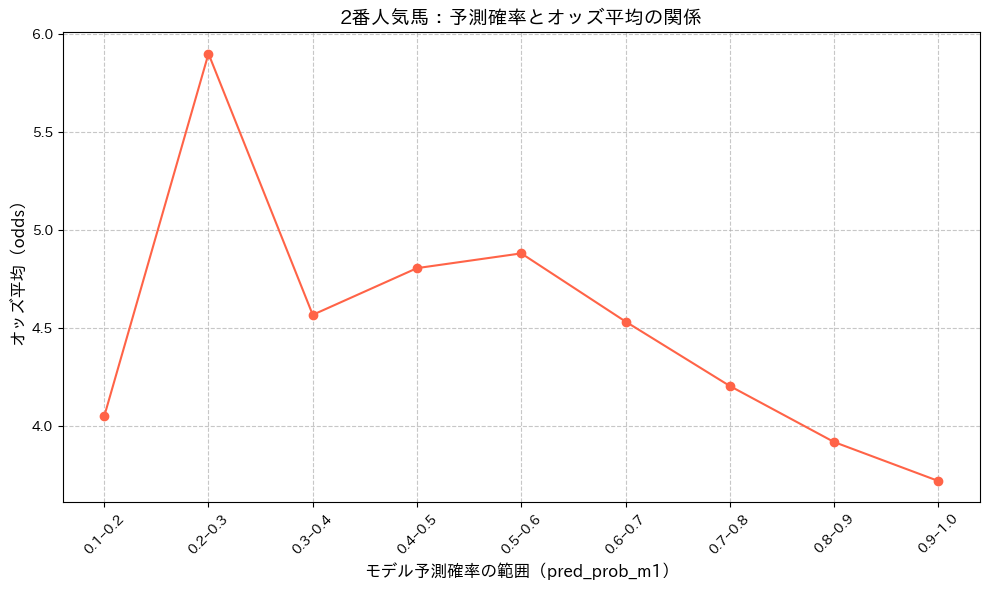

  prob_bin  サンプル数     オッズ平均
0  0.0–0.1      0       NaN
1  0.1–0.2      8  4.050000
2  0.2–0.3     18  5.900000
3  0.3–0.4     34  4.567647
4  0.4–0.5    102  4.805882
5  0.5–0.6    239  4.881172
6  0.6–0.7    402  4.533333
7  0.7–0.8    492  4.204675
8  0.8–0.9    320  3.918750
9  0.9–1.0     30  3.720000


In [41]:
# ▼ パラメータ（任意の人気を指定）
target_popularity = 2

# ▼ 1. 指定人気だけ抽出
df_fixed_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ 2. モデル予測確率でビン分け（0.0〜1.0 を 0.1刻み）
bins = np.arange(0, 1.01, 0.1)
labels = [f'{round(bins[i],2)}–{round(bins[i+1],2)}' for i in range(len(bins)-1)]
df_fixed_pop['prob_bin'] = pd.cut(df_fixed_pop['pred_prob_m1'], bins=bins, labels=labels, include_lowest=True)

# ▼ 3. 各ビンごとのオッズ平均を計算
odds_stats = (
    df_fixed_pop.groupby('prob_bin')
    .agg(
        サンプル数=('odds', 'count'),
        オッズ平均=('odds', 'mean')
    )
    .reset_index()
)

# ▼ 4. グラフ表示
plt.figure(figsize=(10, 6))
plt.plot(odds_stats['prob_bin'], odds_stats['オッズ平均'], marker='o', linestyle='-', color='tomato')
plt.xlabel('モデル予測確率の範囲（pred_prob_m1）', fontsize=12)
plt.ylabel('オッズ平均（odds）', fontsize=12)
plt.title(f'{target_popularity}番人気馬：予測確率とオッズ平均の関係', fontsize=14)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ▼ 表の出力（確認用）
print(odds_stats)

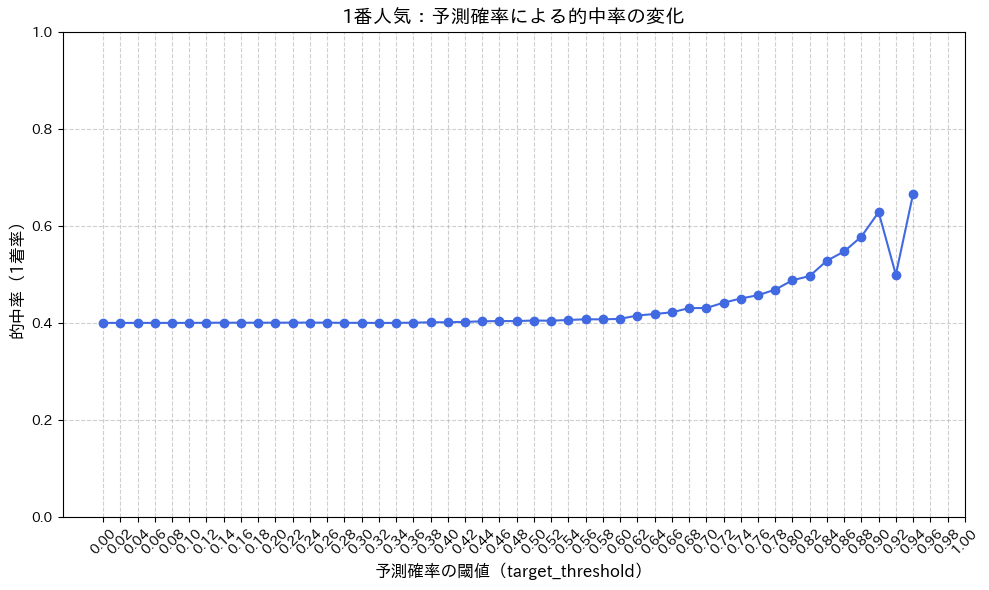

In [343]:
import numpy as np
import matplotlib.pyplot as plt

# ▼ 指定する人気
target_popularity = 1

# ▼ データのフィルタ：指定人気の馬だけ
df_target_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ 閾値の範囲（0.0〜1.0 を 0.05刻みで）
thresholds = np.arange(0.0, 1.01, 0.02)

hit_rates = []  # 的中率リスト

for thresh in thresholds:
    df_thresh = df_target_pop[df_target_pop['pred_prob_m1'] >= thresh]
    total = len(df_thresh)
    if total == 0:
        hit_rate = np.nan  # データなしの場合はNaN
    else:
        hits = (df_thresh['finish_rank'] == 1).sum()
        hit_rate = hits / total
    hit_rates.append(hit_rate)

# ▼ グラフの描画
plt.figure(figsize=(10, 6))
plt.plot(thresholds, hit_rates, marker='o', linestyle='-', color='royalblue')
plt.xlabel('予測確率の閾値（target_threshold）', fontsize=12)
plt.ylabel('的中率（1着率）', fontsize=12)
plt.title(f'{target_popularity}番人気：予測確率による的中率の変化', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(np.round(thresholds, 2), rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.show()


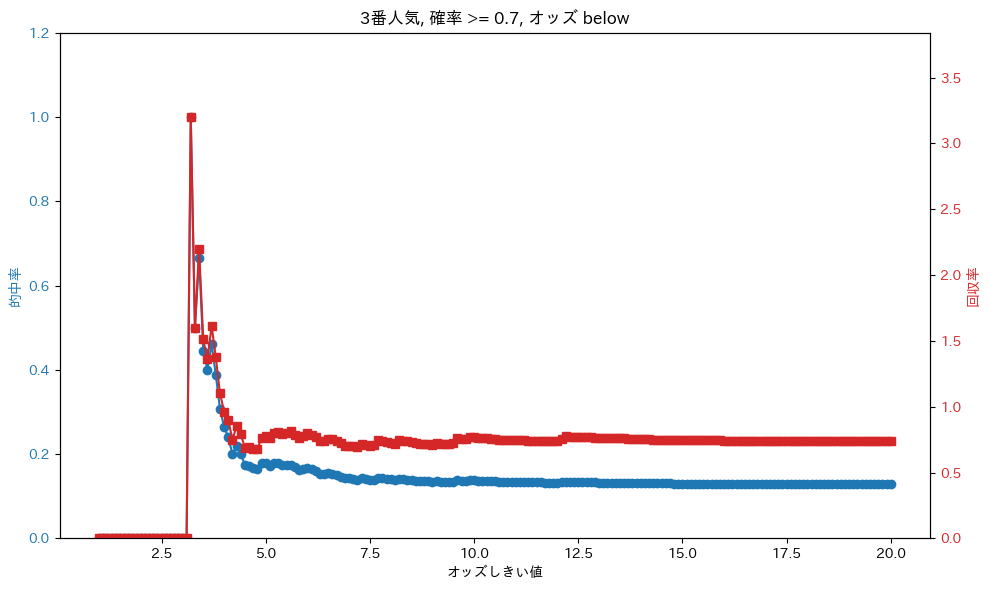

In [121]:
# ▼ パラメータ設定
target_popularity = 3
prob_threshold = 0.7
odds_min = 1.0
odds_max = 20
odds_step = 0.1
filter_type = 'below'  # 'below' or 'above'

# ▼ 該当人気だけに絞る
df_pop = full_pred_df[full_pred_df['popularity'] == target_popularity].copy()

# ▼ モデル予測確率が高い馬を抽出
df_high_prob = df_pop[df_pop['pred_prob_m1'] >= prob_threshold].copy()

# ▼ 結果記録リスト
odds_thresholds = []
hit_rates = []
rois = []
sample_sizes = []

# ▼ オッズしきい値を変化させながら集計
odds_range = np.arange(odds_min, odds_max + odds_step, odds_step)

for threshold in odds_range:
    if filter_type == 'below':
        subset = df_high_prob[df_high_prob['odds'] <= threshold].copy()
    elif filter_type == 'above':
        subset = df_high_prob[df_high_prob['odds'] > threshold].copy()
    else:
        raise ValueError("filter_type は 'below' または 'above' にしてください")

    sample_size = len(subset)
    hit_count = (subset['finish_rank'] == 1).sum()
    return_sum = subset.loc[subset['finish_rank'] == 1, 'odds'].sum()

    hit_rate = hit_count / sample_size if sample_size > 0 else 0
    roi = return_sum / sample_size if sample_size > 0 else 0

    # 結果記録
    odds_thresholds.append(threshold)
    hit_rates.append(hit_rate)
    rois.append(roi)
    sample_sizes.append(sample_size)

# ▼ グラフ表示（的中率 & 回収率の2軸）
fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = 'tab:blue'
ax1.set_xlabel('オッズしきい値')
ax1.set_ylabel('的中率', color=color1)
ax1.plot(odds_thresholds, hit_rates, color=color1, label='的中率', marker='o')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_ylim(0, max(hit_rates) * 1.2)

# ▼ 回収率の軸
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('回収率', color=color2)
ax2.plot(odds_thresholds, rois, color=color2, label='回収率', marker='s')
ax2.tick_params(axis='y', labelcolor=color2)
ax2.set_ylim(0, max(rois) * 1.2)

# ▼ タイトル・凡例
plt.title(f'{target_popularity}番人気, 確率 >= {prob_threshold}, オッズ {filter_type}')
fig.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.savefig("C:\\Users\\ryo\\Downloads\\plot.png")
plt.show()


C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_pop.groupby('odds_bin')
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:50: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layo

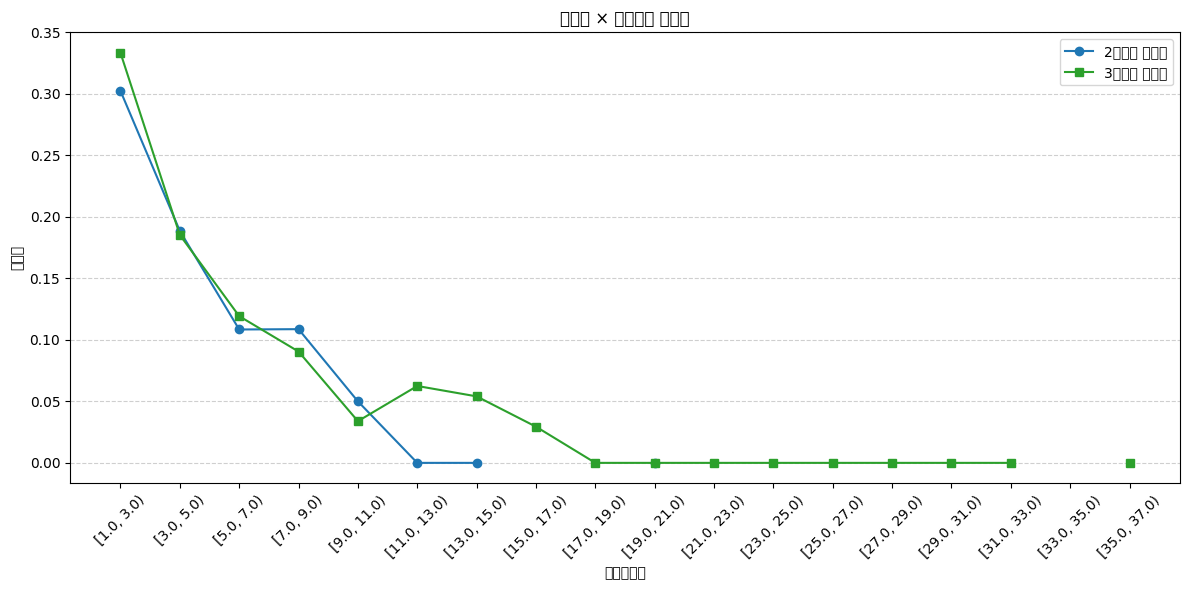

C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12458 (\N{KATAKANA LETTER O}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 12474 (\N{KATAKANA LETTER ZU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 31684 (\N{CJK UNIFIED IDEOGRAPH-7BC4}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22258 (\N{CJK UNIFIED IDEOGRAPH-56F2}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\ryo\AppData\Local\Temp\ipykernel_10696\163086358.py:68: UserWarning: Glyph 22238 (\N{CJK UNIFIED IDEOGRAPH-56DE}) missin

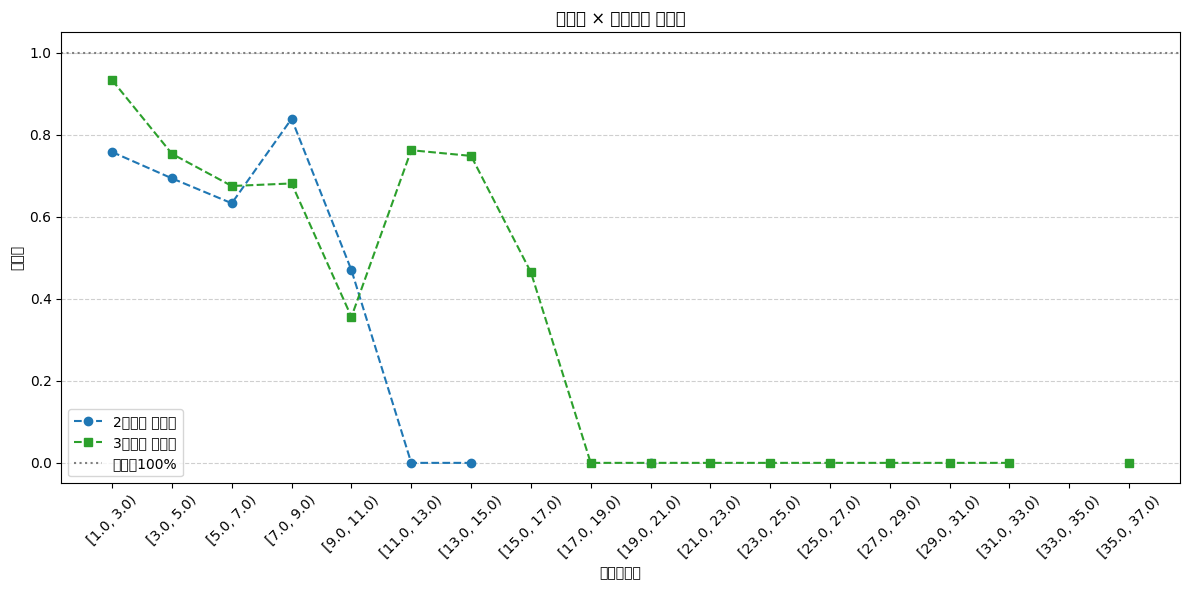

In [39]:

# -------- パラメータ --------
odds_bins = np.arange(1.0, 51.0, 2.0)  # オッズを2刻みで分割
target_popularities = [2, 3]           # 比較したい人気

# -------- データ収集 --------
plot_data = {}

for pop in target_popularities:
    df_pop = full_pred_df[full_pred_df['popularity'] == pop].copy()
    if df_pop.empty:
        continue

    df_pop['odds_bin'] = pd.cut(df_pop['odds'], bins=odds_bins, right=False)
    df_pop['hit'] = (df_pop['finish_rank'] == 1).astype(int)
    df_pop['return'] = df_pop['odds'] * df_pop['hit']

    stats = (
        df_pop.groupby('odds_bin')
        .agg(
            sample_size=('hit', 'count'),
            hit_count=('hit', 'sum'),
            return_sum=('return', 'sum')
        )
        .reset_index()
    )

    stats['hit_rate'] = stats['hit_count'] / stats['sample_size']
    stats['roi'] = stats['return_sum'] / stats['sample_size']
    stats['odds_bin_str'] = stats['odds_bin'].astype(str)
    plot_data[pop] = stats

# -------- 共通設定 --------
colors = ['tab:blue', 'tab:green', 'tab:red', 'tab:orange', 'tab:purple']
markers = ['o', 's', 'D', '^', 'v']

# -------- グラフ①：的中率 --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['hit_rate'],
             label=f'{pop}番人気 的中率',
             color=colors[i % len(colors)], marker=markers[i % len(markers)])

plt.xlabel('オッズ範囲')
plt.ylabel('的中率')
plt.title('人気別 × オッズ別 的中率')
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# -------- グラフ②：回収率 --------
plt.figure(figsize=(12, 6))
for i, pop in enumerate(target_popularities):
    stats = plot_data[pop]
    plt.plot(stats['odds_bin_str'], stats['roi'],
             label=f'{pop}番人気 回収率',
             color=colors[i % len(colors)], marker=markers[i % len(markers)], linestyle='--')

plt.xlabel('オッズ範囲')
plt.ylabel('回収率')
plt.title('人気別 × オッズ別 回収率')
plt.xticks(rotation=45)
plt.axhline(y=1.0, color='gray', linestyle='dotted', label='回収率100%')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:43:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


正答率 (accuracy): 0.6608
混同行列:
 [[ 17 114]
 [ 21 246]]
分類レポート:
               precision    recall  f1-score   support

           0       0.45      0.13      0.20       131
           1       0.68      0.92      0.78       267

    accuracy                           0.66       398
   macro avg       0.57      0.53      0.49       398
weighted avg       0.61      0.66      0.59       398


-------------------------


▼ 評価結果（3番人気）
  全体のレース数       : 398
  モデルが1と予測した数 : 360
  的中数（1着）         : 48
  払い戻し合計           : 271.90
  回収率                 : 0.7553（75.53%）
▼ 確率で購入判断（しきい値 = 0.7 ）
対象人気           : 3番人気
全体レース数       : 398
購入対象レース数   : 42
的中数             : 12
的中率             : 0.2857（28.57%）
回収率             : 1.1595（115.95%）
          feature  importance
2  pop3_pred_prob    2.988739
1  pop2_pred_prob    2.768800
6  pop7_pred_prob    2.728132
7  pop8_pred_prob    2.662507
3  pop4_pred_prob    2.534038
0  pop1_pred_prob    2.490656
5  pop6_pred_prob    2.403370
4  pop5_pred_prob    2.284997

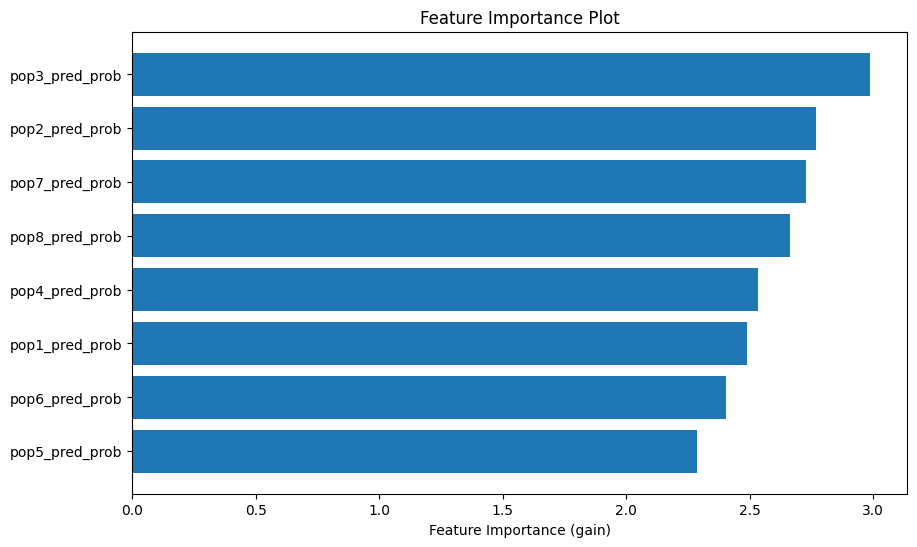

In [205]:
# 1. 人気が重複しているレースIDを特定
pop_counts = full_pred_df.groupby(['race_id', 'popularity']).size().reset_index(name='count')
duplicated_pops = pop_counts[pop_counts['count'] > 1]['race_id'].unique()

# 2. full_pred_df から除外（重複人気を含むレースは全除外）
clean_df = full_pred_df[~full_pred_df['race_id'].isin(duplicated_pops)].copy()

# 3. 人気ごとの予測確率を横持ちにする（pivot）
feature_df = clean_df.copy()
feature_df['pop_col'] = feature_df['popularity'].apply(lambda x: f'pop{x}_pred_prob')
X_all = feature_df.pivot(index='race_id', columns='pop_col', values='pred_prob_m1').reset_index()

# 4. ターゲット人気の目的変数作成（例：3番人気が1着かどうか）
target_popularity = 3
y_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'finish_rank']].copy()
y_df['target'] = (y_df['finish_rank'] <= 4).astype(int)

# 5. 学習用にマージ
data = pd.merge(X_all, y_df[['race_id', 'target']], on='race_id', how='inner')

# 6. 特徴量・目的変数に分割
X = data.drop(columns=['race_id', 'target'])
y = data['target']

# 7. モデル学習（例：XGBoost）
from sklearn.model_selection import train_test_split
import xgboost as xgb

# race_id の先頭2桁から「年」を抽出（文字列として処理）
data['year'] = data['race_id'].astype(str).str[:2]

# 学習データ：2023年（= '23'）
train_data = data[data['year'] == '23']
X_train = train_data.drop(columns=['race_id', 'target', 'year'])
y_train = train_data['target']

# 検証データ：2024年（= '24'）
val_data = data[data['year'] == '24']
X_val = val_data.drop(columns=['race_id', 'target', 'year'])
y_val = val_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# ====== パラメータ定義 ======
xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'use_label_encoder': False,
    'random_state': 42,
    'n_estimators': 100,
    'max_depth': 4,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 1.0,
}

# ====== モデル定義 ======
model = xgb.XGBClassifier(**xgb_params)
model.fit(X_train, y_train)

# 8. 評価
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(X_val)

# モデル予測
y_pred = model.predict(X_val)

# X_val に race_id を付与（元のデータから取得）
X_val_with_preds = X_val.copy()
X_val_with_preds['race_id'] = data.loc[X_val.index, 'race_id'].values
X_val_with_preds['y_true'] = y_val.values
X_val_with_preds['y_pred'] = y_pred

# race_id 単位で重複を除く（1人気あたり1行）
target_df = clean_df[clean_df['popularity'] == target_popularity][['race_id', 'odds', 'finish_rank', 'popularity']].copy()

# 予測結果と統合
eval_df = pd.merge(X_val_with_preds, target_df, on='race_id', how='left')

# ✅ 全体のレース数（重複除いてカウント）
total_races = eval_df['race_id'].nunique()

# ✅ 予測が1（=購入対象）のレースだけ抽出
bets = eval_df[eval_df['y_pred'] == 1].copy()
bets['hit'] = (bets['finish_rank'] == 1).astype(int)  # 的中 = 1着

# 購入数、的中数、払い戻し合計
num_bets = len(bets)
num_hits = bets['hit'].sum()
total_return = (bets['odds'] * bets['hit']).sum()
roi = total_return / num_bets if num_bets > 0 else 0
# 評価指標
acc = accuracy_score(y_val, y_pred)
cm = confusion_matrix(y_val, y_pred)
report = classification_report(y_val, y_pred)

print(f"正答率 (accuracy): {acc:.4f}")
print("混同行列:\n", cm)
print("分類レポート:\n", report)
print("\n-------------------------\n")
# ✅ 出力
print(f"\n▼ 評価結果（{target_popularity}番人気）")
print(f"  全体のレース数       : {total_races}")
print(f"  モデルが1と予測した数 : {num_bets}")
print(f"  的中数（1着）         : {num_hits}")
print(f"  払い戻し合計           : {total_return:.2f}")
print(f"  回収率                 : {roi:.4f}（{roi:.2%}）")

# ====== パラメータ設定 ======
prob_threshold = 0.7      # 購入する確率のしきい値（例：0.7）
odds_threshold = 4.5      # 購入するオッズのしきい値（例：3.0）

# ====== 予測確率の取得 ======
y_proba = model.predict_proba(X_val)[:, 1]  # クラス1（1着になる確率）のみ

# ====== データ結合 ======
# X_val には race_id などの情報がないので、feature_df から race_id, odds, finish_rank を取得
val_df_with_info = eval_df[eval_df['popularity'] == target_popularity].copy()
val_df_with_info = val_df_with_info.reset_index(drop=True)  # 念のため整列

val_df_with_info['pred_prob'] = y_proba
val_df_with_info['hit'] = (val_df_with_info['finish_rank'] == 1).astype(int)

# ====== 購入するレース（確率が高いもの） ======
bets = val_df_with_info[
    (val_df_with_info['pred_prob'] >= prob_threshold) &
    (val_df_with_info['odds'] <= odds_threshold)
].copy()

# ====== 回収率・的中率計算 ======
race_count_total = len(val_df_with_info)
race_count_bet = len(bets)
hit_count = bets['hit'].sum()
hit_rate = hit_count / race_count_bet if race_count_bet > 0 else 0
total_return = bets.loc[bets['hit'] == 1, 'odds'].sum()
roi = total_return / race_count_bet if race_count_bet > 0 else 0

# ====== 結果表示 ======
print("▼ 確率で購入判断（しきい値 =", prob_threshold, "）")
print(f"対象人気           : {target_popularity}番人気")
print(f"全体レース数       : {race_count_total}")
print(f"購入対象レース数   : {race_count_bet}")
print(f"的中数             : {hit_count}")
print(f"的中率             : {hit_rate:.4f}（{hit_rate:.2%}）")
print(f"回収率             : {roi:.4f}（{roi:.2%}）")

# ====== オプション：CSV出力 ======
bets.to_csv(f'pop{target_popularity}_prob{prob_threshold}_bets.csv', index=False, encoding='cp932')

import matplotlib.pyplot as plt
import xgboost as xgb

# 1. 特徴量重要度の取得（gain, weight, cover などいろいろありますが、'gain'がよく使われます）
importance = model.get_booster().get_score(importance_type='gain')

# 2. 辞書 → DataFrame に変換して見やすく
import pandas as pd

importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values(by='importance', ascending=False)

print(importance_df)

# 3. 棒グラフで可視化
plt.figure(figsize=(10,6))
plt.barh(importance_df['feature'], importance_df['importance'])
plt.gca().invert_yaxis()  # 重要度の高い順に表示
plt.xlabel('Feature Importance (gain)')
plt.title('Feature Importance Plot')
plt.show()


C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 36092 (\N{CJK UNIFIED IDEOGRAPH-8CFC}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20837 (\N{CJK UNIFIED IDEOGRAPH-5165}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12375 (\N{HIRAGANA LETTER SI}) missing from font(s) DejaVu Sans.
  fig.canvas.pr

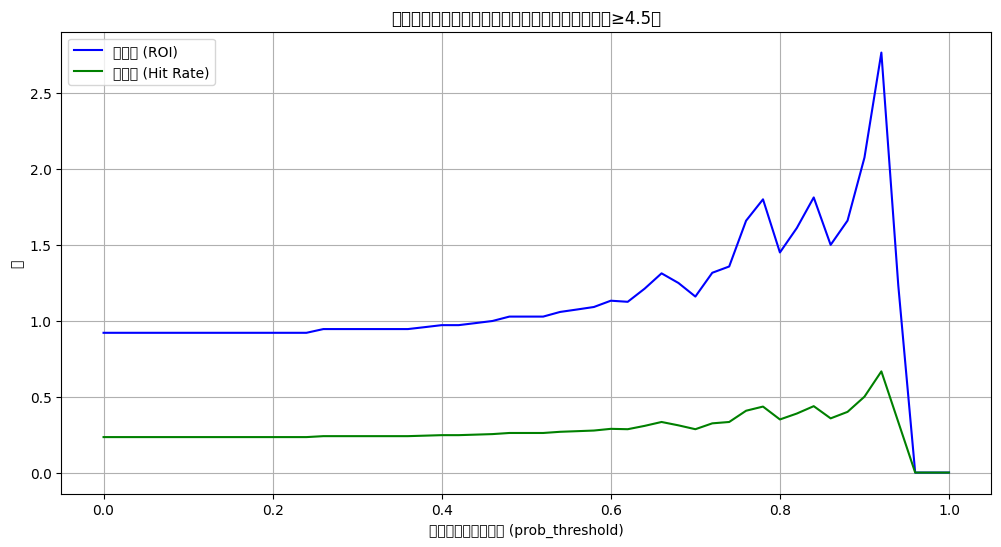

C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 23550 (\N{CJK UNIFIED IDEOGRAPH-5BFE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35937 (\N{CJK UNIFIED IDEOGRAPH-8C61}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12524 (\N{KATAKANA LETTER RE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\ryo\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canva

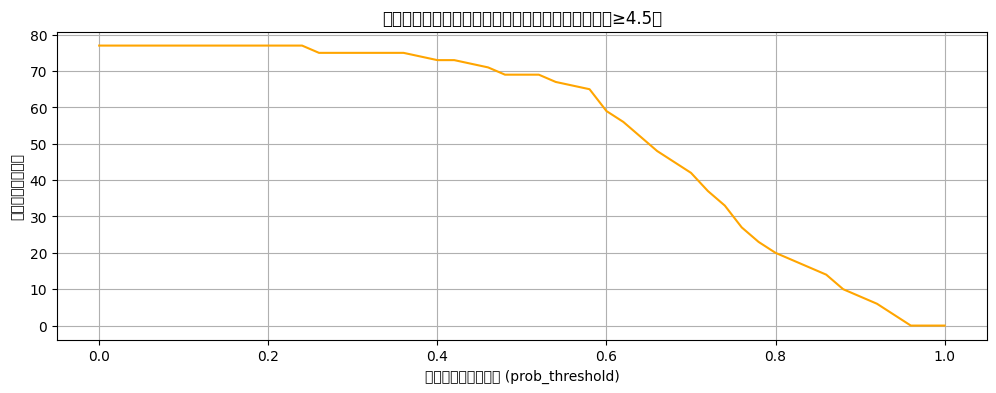

In [207]:
import numpy as np
import matplotlib.pyplot as plt

# 確率のしきい値（0〜1）
thresholds = np.arange(0.0, 1.01, 0.02)

roi_list = []
hit_rate_list = []
bet_count_list = []

for thr in thresholds:
    # 確率とオッズ両方の条件で購入判断
    bets_thr = val_df_with_info[
        (val_df_with_info['pred_prob'] >= thr) &
        (val_df_with_info['odds'] <= odds_threshold)
    ].copy()
    
    num_bets = len(bets_thr)
    if num_bets > 0:
        hits = bets_thr['hit'].sum()
        hit_rate = hits / num_bets
        total_return = bets_thr.loc[bets_thr['hit'] == 1, 'odds'].sum()
        roi = total_return / num_bets
    else:
        hit_rate = 0
        roi = 0
    
    roi_list.append(roi)
    hit_rate_list.append(hit_rate)
    bet_count_list.append(num_bets)

# グラフ描画
plt.figure(figsize=(12,6))
plt.plot(thresholds, roi_list, label='回収率 (ROI)', color='blue')
plt.plot(thresholds, hit_rate_list, label='的中率 (Hit Rate)', color='green')
plt.xlabel('購入確率のしきい値 (prob_threshold)')
plt.ylabel('率')
plt.title(f'購入確率しきい値ごとの回収率と的中率（オッズ≥{odds_threshold}）')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,4))
plt.plot(thresholds, bet_count_list, label='購入対象レース数', color='orange')
plt.xlabel('購入確率のしきい値 (prob_threshold)')
plt.ylabel('購入対象レース数')
plt.title(f'購入確率しきい値ごとの購入対象レース数（オッズ≥{odds_threshold}）')
plt.grid(True)
plt.show()
